EVA Group Members - 
1. Ravil Kashyap (ravilkashyap619@gmail.com)
2. Samir (paulsamir2010@yahoo.com)
3. Mohan Papasani (papasani.mohansrinivas@gmail.com)
4. Hardayal Singh (hardayal.msit@gmail.com)

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
class ConvReluBatchNorm(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=(3,3), dropout=0.15, padding=0, **kwargs):
    super(ConvReluBatchNorm, self).__init__()
    self.convblock = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, **kwargs),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(p=dropout)
    )

  def forward(self, inp):
    return self.convblock(inp)



In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = ConvReluBatchNorm(in_channels=1, out_channels=10) #input -? OUtput? RF
        self.conv2 = ConvReluBatchNorm(in_channels=10, out_channels=14)
        self.conv3 = ConvReluBatchNorm(in_channels=14, out_channels=20, dropout=0)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv4 = ConvReluBatchNorm(in_channels=20, out_channels=10, kernel_size=(1,1))
        self.conv5 = ConvReluBatchNorm(in_channels=10, out_channels=14)
        self.conv6 = ConvReluBatchNorm(in_channels=14, out_channels=16)
        self.conv7 = ConvReluBatchNorm(in_channels=16, out_channels=20, dropout=0)
        self.conv8 = ConvReluBatchNorm(in_channels=20, out_channels=24, dropout=0)
        self.conv9 = nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(3, 3), padding=0)
        self.bnorm = nn.BatchNorm2d(10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.bnorm(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
 ConvReluBatchNorm-5           [-1, 10, 26, 26]               0
            Conv2d-6           [-1, 14, 24, 24]           1,274
              ReLU-7           [-1, 14, 24, 24]               0
       BatchNorm2d-8           [-1, 14, 24, 24]              28
           Dropout-9           [-1, 14, 24, 24]               0
ConvReluBatchNorm-10           [-1, 14, 24, 24]               0
           Conv2d-11           [-1, 20, 22, 22]           2,540
             ReLU-12           [-1, 20, 22, 22]               0
      BatchNorm2d-13           [-1, 20, 22, 22]              40
          Dropout-14           [-1, 20,

In [5]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


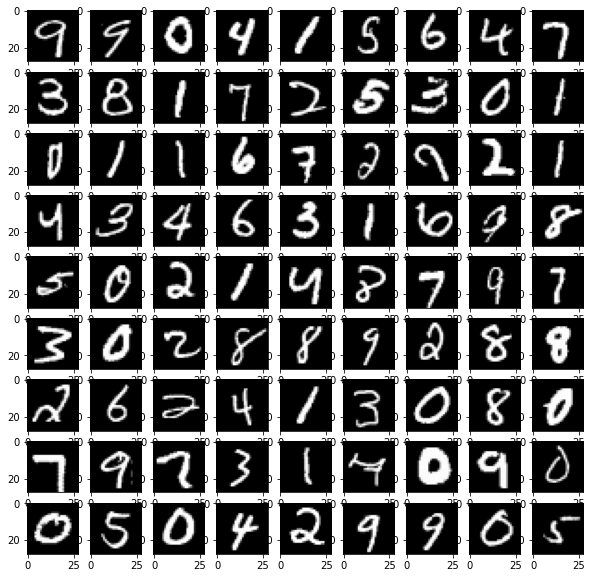

In [6]:
# Display training images
plt.figure(figsize=(10,10))
for i in range(9*9):
    plt.subplot(9,9,i+1)   
    imgs, lbls = next(iter(train_loader))
    plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray") 
    # plt.imshow(img[i,:,:16])

plt.show()

In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # calc accuracy
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # calc loss
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    return loss, correct / len(train_loader.dataset)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

In [8]:
acc_thresh = 0.994
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

epochs = 20

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, epochs):
    print(f"Epoch - {epoch}")
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc =  test(model, device, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_acc > acc_thresh:
      break

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch - 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9848/10000 (98.4800%)

Epoch - 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9902/10000 (99.0200%)

Epoch - 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9913/10000 (99.1300%)

Epoch - 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9913/10000 (99.1300%)

Epoch - 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9913/10000 (99.1300%)

Epoch - 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.2000%)

Epoch - 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.2400%)

Epoch - 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.3000%)

Epoch - 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.3000%)

Epoch - 10


loss=0.03638502582907677 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]



Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.4200%)



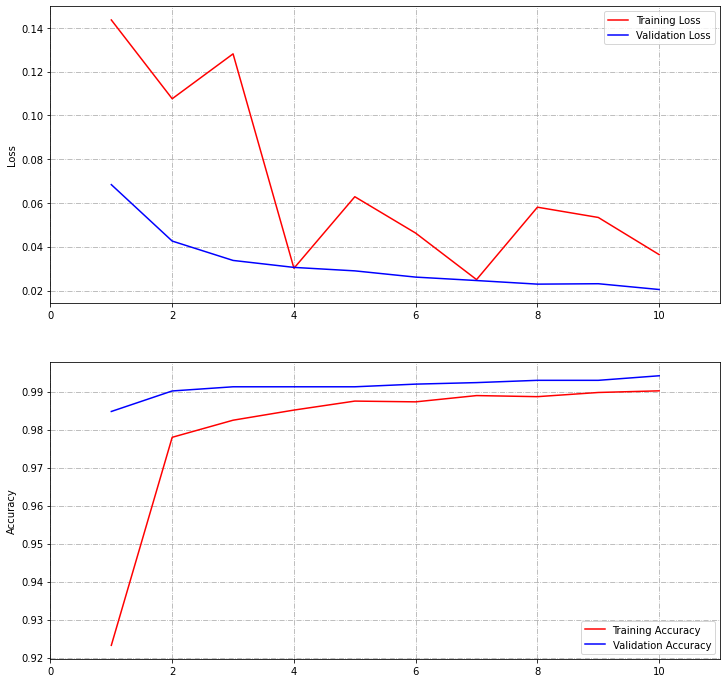

In [9]:
# plot training history

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, epoch + 1])
plt.ylabel('Loss')
plt.plot(range(1, epoch + 1), train_losses[:epoch], 'r', label='Training Loss')
plt.plot(range(1, epoch + 1), test_losses[:epoch], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, epoch+1])
plt.ylabel('Accuracy')
plt.plot(range(1, epoch + 1), train_accuracies[:epoch], 'r', label='Training Accuracy')
plt.plot(range(1, epoch + 1), test_accuracies[:epoch], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

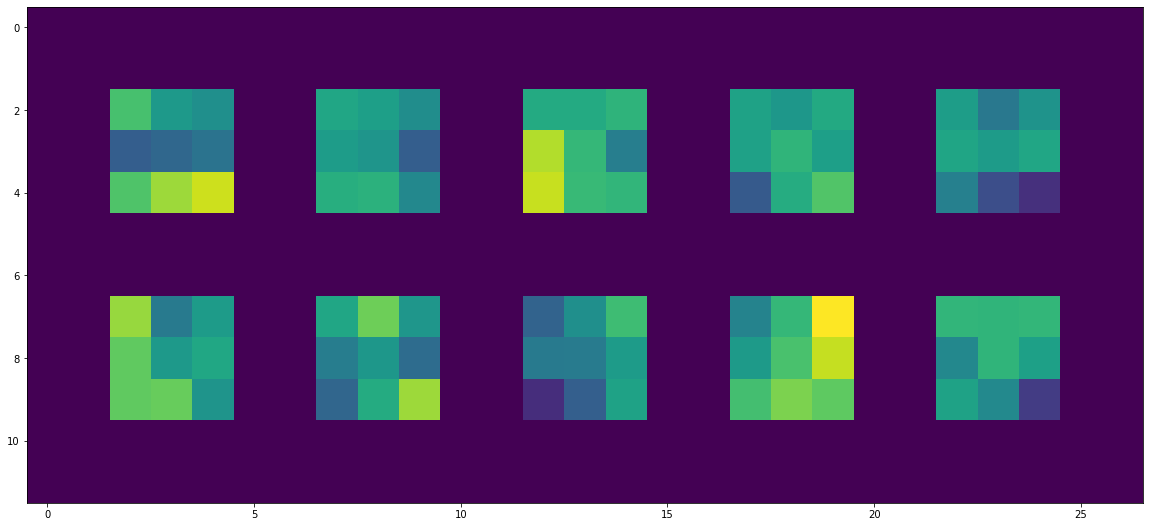

In [39]:
# visualise kernels (the last layer conv9 3x3 kernels)

from torchvision.utils import make_grid

kernels = model.conv9.weight.detach().clone().cpu()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
img = make_grid(kernels.cpu(), nrow=5)

plt.figure(figsize=(20, 20))
for i in range(1):
    plt.subplot(1,1,i+1)    
    plt.imshow(img[i,:,:])

plt.show()

In [ ]:
# TO DO
#Misclassifications